## Group No -> 23
    
## Group Member Details:
| Sr.No | Student Name | Student ID |
| --- | --- | --- |
| 1 | HARMANAN GURVINDER KOHLI | 2021SC04823 |
| 2 | SURVE BHAKTI PRAKASH SMITA |2021SC04075 |
| 3 | TRIVEDI TEJAS ATUL KAPILA | 2021SC04267 |
| 4 | SUNRIT PAL | 2021SC04088 |

### Importing Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf   # we have used tensorflow==2.10.0
import random
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical

In [2]:
# Setting the seeds so that the results are reproducible
random.seed(42)
np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Colab was used for all the tasks performed in this jupyter notebook. Hence mounting the drive for reading the data

### Loading the data

Loading the data file and using '\t' as the delimiter

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/lyrics.csv",  sep='\t')
df.head()

,song_id,lyrics
0,3e9HZxeyfWwjeyPAMmWSSQ,['[Verse 1]\nThought I\'d end up with Sean\nBu...
1,5p7ujcrUXASCNwRaWNHR1C,"[""[Verse 1]\nFound you when your heart was bro..."
2,2xLMifQCjDGFmkHkpNLD9h,"['[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun..."
3,3KkXRkHbMCARz0aVfEt68P,NaN
4,1rqqCSm0Qe4I9rUvWncaom,"[""[Intro]\nHigh, high hopes\n\n[Chorus]\nHad t..."


### Removing the null values

In [5]:
# checking the shape of dataset
df.shape

(20404, 2)

In [6]:
# checking if any null values are present in the dataset
df.isnull().sum()

song_id      0
lyrics     741
dtype: int64

In [7]:
# drop null values from the current dataframe
df.dropna(inplace = True)
df.shape

(19663, 2)

All the null values have been removed from the dataset

In [8]:
df.duplicated().sum()

0

As you can see we have no duplicates

### Data Preprocessing

Data is a stringified list which has meta labeling in the form of a text between tags.

In [9]:
df['lyrics'][0]

'[\'[Verse 1]\\nThought I\\\'d end up with Sean\\nBut he wasn\\\'t a match\\nWrote some songs about Ricky\\nNow I listen and laugh\\nEven almost got married\\nAnd for Pete, I\\\'m so thankful\\nWish I could say, "Thank you" to Malcolm\\n\\\'Cause he was an angel\\n\\n[Pre-Chorus]\\nOne taught me love\\nOne taught me patience\\nAnd one taught me pain\\nNow, I\\\'m so amazing\\nSay I\\\'ve loved and I\\\'ve lost\\nBut that\\\'s not what I see\\nSo, look what I got\\nLook what you taught me\\nAnd for that, I say\\n\\n[Chorus]\\nThank you, next (Next)\\nThank you, next (Next)\\nThank you, next\\nI\\\'m so fuckin\\\' grateful for my ex\\nThank you, next (Next)\\nThank you, next (Next)\\nThank you, next (Next)\\nI\\\'m so fuckin\\\'—\\n\\n[Verse 2]\\nSpend more time with my friends\\nI ain\\\'t worried \\\'bout nothin\\\'\\nPlus, I met someone else\\nWe havin\\\' better discussions\\nI know they say I move on too fast\\nBut this one gon\\\' last\\n\\\'Cause her name is Ari\\nAnd I\\\'m so go

Let's start by removing the outer brackets

In [10]:
def remove_brackets(x):
    """function removes the outer brackets from the text"""
    m = []
    # for each row in the dataset
    for i in x:
      # removing the outer brackets
        m.append(str(i[2:-2]))
    # returning the output
    return m
df['lyrics'] = remove_brackets(df['lyrics'])
df.head()

,song_id,lyrics
0,3e9HZxeyfWwjeyPAMmWSSQ,[Verse 1]\nThought I\'d end up with Sean\nBut ...
1,5p7ujcrUXASCNwRaWNHR1C,[Verse 1]\nFound you when your heart was broke...
2,2xLMifQCjDGFmkHkpNLD9h,"[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun i..."
4,1rqqCSm0Qe4I9rUvWncaom,"[Intro]\nHigh, high hopes\n\n[Chorus]\nHad to ..."
5,0bYg9bo50gSsH3LtXe2SQn,[Intro]\nI-I-I don't want a lot for Christmas\...


We can see that the outer brackets have been removed. Now we change the text to lower case, remove extra spaces, unwanted brackets and special characters. Meta-labels inside the square brackets are removed using regular expression.

In [11]:
def preprocessing(text):
    """function to perform preprocessing on the text"""
    # removing the nextline characters
    text = text.replace("\\n"," ")
    # making the text consistent by replacing all the characters by their uncapitalized characters
    text = text.lower()
    # removing all the remaining brackets
    text = re.sub(r'\[.*?\]'," ",text)
    # removing all special characters except numberd and alphabets
    text = re.sub("[^a-z0-9'\.\n]"," ", text)
    # removing all the unnecessary spaces
    text = re.sub(' +', ' ', text)
    # removing the leading or trailing spaces from the text
    text = text.strip()
    # returning the output
    return text

df["cleaned_text"] = df["lyrics"].apply(lambda text: preprocessing(text))
df.head()

,song_id,lyrics,cleaned_text
0,3e9HZxeyfWwjeyPAMmWSSQ,[Verse 1]\nThought I\'d end up with Sean\nBut ...,thought i 'd end up with sean but he wasn 't a...
1,5p7ujcrUXASCNwRaWNHR1C,[Verse 1]\nFound you when your heart was broke...,found you when your heart was broke i filled y...
2,2xLMifQCjDGFmkHkpNLD9h,"[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun i...",astro yeah sun is down freezin ' cold that 's ...
4,1rqqCSm0Qe4I9rUvWncaom,"[Intro]\nHigh, high hopes\n\n[Chorus]\nHad to ...",high high hopes had to have high high hopes fo...
5,0bYg9bo50gSsH3LtXe2SQn,[Intro]\nI-I-I don't want a lot for Christmas\...,i i i don't want a lot for christmas there is ...


All the test has been cleaned and added into a new column named **cleaned_text**

In [12]:
df["cleaned_text"][0]

"thought i 'd end up with sean but he wasn 't a match wrote some songs about ricky now i listen and laugh even almost got married and for pete i 'm so thankful wish i could say thank you to malcolm 'cause he was an angel one taught me love one taught me patience and one taught me pain now i 'm so amazing say i 've loved and i 've lost but that 's not what i see so look what i got look what you taught me and for that i say thank you next next thank you next next thank you next i 'm so fuckin ' grateful for my ex thank you next next thank you next next thank you next next i 'm so fuckin ' spend more time with my friends i ain 't worried 'bout nothin ' plus i met someone else we havin ' better discussions i know they say i move on too fast but this one gon ' last 'cause her name is ari and i 'm so good with that so good with that she taught me love love she taught me patience patience how she handles pain pain that shit 's amazing yeah she 's amazing i 've loved and i 've lost yeah yeah b

We can see from the output post pre-processing that all the un-needed elements have been removed

### Vectorizing the text into numeric form

In [19]:
lyrics = []
# for each row in the cleaned_text column
for i  in df.cleaned_text:
  # add the first 100 characters
    lyrics.extend(i[:100])

We are taking the first 100 characters from each song for vectorization.<br>**Using entire data causes the memory to overflow and the program crashes everytime.**

In [20]:
# finding the unique characters in the dataset
vocab = sorted(set(lyrics))
print("There are", len(vocab), "unique characters in the lyrics column")

There are 39 unique characters in the lyrics column


We can see we have 39 unique characters that we need to convert into numeric form so that can pass them as the input to the model

Converting the text into numerical form

In [21]:
# Create a mapping from character to unique index..
char_to_int = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char_to_ind and allows us to convert back
#   from unique index to the character in our vocabulary.
int_to_char = np.array(vocab)

In [22]:
# Printing the first 10 character mapping
for char,_ in zip(char_to_int, range(10)):
    print(str(char)+" : "+ str(char_to_int[char]))

  : 0
' : 1
. : 2
0 : 3
1 : 4
2 : 5
3 : 6
4 : 7
5 : 8
6 : 9


In [23]:
def vectorize(lyrics):
    """function to vectorizing the text into its numeric representation"""
    vect_lyrics = np.array([char_to_int[i] for i in lyrics])
    return vect_lyrics
vect_lyrics = vectorize(lyrics)

In [24]:
print(str(lyrics[:10])+" is converted to " + str(vect_lyrics[:10]))

['t', 'h', 'o', 'u', 'g', 'h', 't', ' ', 'i', ' '] is converted to [32 20 27 33 19 20 32  0 21  0]


We have mapped the characters to a unique number which will serve as numeric form and will be given as a input to the model

### Splitting the data into features and target

In this section we are splitting the data into features and targets

In [25]:
# prepare the dataset as input & output pairs encoded as integers
seq_length = 50
_x = []
_y = []
n = len(lyrics)
# looping over the data
for i in range(0,n-seq_length,1):
  # getting the numeric form of the text of sequence length = 50
    _in = vect_lyrics[i:i+seq_length]
    # adding the output
    _out = vect_lyrics[i+seq_length]
    # adding the data into features
    _x.append(_in)
    # adding the output into target variable
    _y.append(_out)

Here we are taking the sequence length of 50 which will be given to the model and model will predict the next character as output

Following code cells is just reshaping the features and targets into appropriate forms which can be given as input to the model

In [26]:
_x = np.reshape(_x, [len(_y), seq_length,1])

In [27]:
print(_x[0])

[[32]
 [20]
 [27]
 [33]
 [19]
 [20]
 [32]
 [ 0]
 [21]
 [ 0]
 [ 1]
 [16]
 [ 0]
 [17]
 [26]
 [16]
 [ 0]
 [33]
 [28]
 [ 0]
 [35]
 [21]
 [32]
 [20]
 [ 0]
 [31]
 [17]
 [13]
 [26]
 [ 0]
 [14]
 [33]
 [32]
 [ 0]
 [20]
 [17]
 [ 0]
 [35]
 [13]
 [31]
 [26]
 [ 0]
 [ 1]
 [32]
 [ 0]
 [13]
 [ 0]
 [25]
 [13]
 [32]]


We can see that the first features dataset is converted to numeric form and is different integers based on the character to interger converstion

In [28]:
print(_y[0])

15


In [29]:
# Normalizing the features
X = (_x) / float(len(vocab))
# Converting the target variable into categories
Y = to_categorical(_y)

In [30]:
print(X[0])

[[0.82051282]
 [0.51282051]
 [0.69230769]
 [0.84615385]
 [0.48717949]
 [0.51282051]
 [0.82051282]
 [0.        ]
 [0.53846154]
 [0.        ]
 [0.02564103]
 [0.41025641]
 [0.        ]
 [0.43589744]
 [0.66666667]
 [0.41025641]
 [0.        ]
 [0.84615385]
 [0.71794872]
 [0.        ]
 [0.8974359 ]
 [0.53846154]
 [0.82051282]
 [0.51282051]
 [0.        ]
 [0.79487179]
 [0.43589744]
 [0.33333333]
 [0.66666667]
 [0.        ]
 [0.35897436]
 [0.84615385]
 [0.82051282]
 [0.        ]
 [0.51282051]
 [0.43589744]
 [0.        ]
 [0.8974359 ]
 [0.33333333]
 [0.79487179]
 [0.66666667]
 [0.        ]
 [0.02564103]
 [0.82051282]
 [0.        ]
 [0.33333333]
 [0.        ]
 [0.64102564]
 [0.33333333]
 [0.82051282]]


We have normalized the feaures dataset between 0 and 1 so that it is easy for the model to converge

In [31]:
Y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

Target variable has been one hot encoded

### Modeling

We are using RNN and LSTM is a type of RNN. Model Architecture is also given below. As this will treated as classification task, we are using softmax function

In [32]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 39)                10023     
                                                                 
Total params: 274,215
Trainable params: 274,215
Non-trainable params: 0
_________________________________________________________________


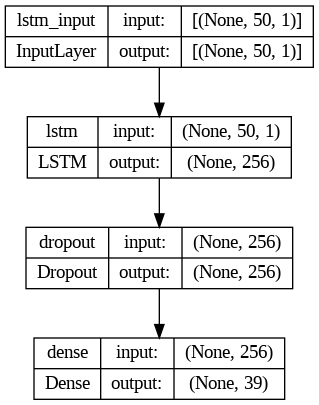

In [33]:
# Visualizing the model
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

For loss categorical crossentropy is taken and for optimizer we are taking adam optimizer

In [35]:
# define the checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Here we are using callbacks.Callbacks are used for application checkpointing which is a fault tolerance technique for long-running processes. In checkpointing a snapshot of the state of the system is taken in case of system failure. If there is a problem, the checkpoint may be used directly or as the starting point for a new run, picking up where it left off.

### Training the model

Model had run in the earlier notebook run and as it takes hours to run so we have not ran it again but saved the model and its history so that it can be used later. This is done due to the problem of timeout in Google colab.

In [ ]:
history = model.fit(X, Y, epochs=10, batch_size=128, callbacks=callbacks_list, validation_split = 0.30, verbose = 1)

Epoch 1/10
10700/10700 [==============================] - ETA: 0s - loss: 2.5281
Epoch 1: loss improved from inf to 2.52812, saving model to weights-improvement-01-2.5281.hdf5
10700/10700 [==============================] - 3259s 304ms/step - loss: 2.5281 - val_loss: 2.3904
Epoch 2/10
10700/10700 [==============================] - ETA: 0s - loss: 2.3041
Epoch 2: loss improved from 2.52812 to 2.30408, saving model to weights-improvement-02-2.3041.hdf5
10700/10700 [==============================] - 3245s 303ms/step - loss: 2.3041 - val_loss: 2.2729
Epoch 3/10
10700/10700 [==============================] - ETA: 0s - loss: 2.1958
Epoch 3: loss improved from 2.30408 to 2.19584, saving model to weights-improvement-03-2.1958.hdf5
10700/10700 [==============================] - 3246s 303ms/step - loss: 2.1958 - val_loss: 2.1703
Epoch 4/10
10700/10700 [==============================] - ETA: 0s - loss: 2.1170
Epoch 4: loss improved from 2.19584 to 2.11699, saving model to weights-improvement-04-2.

### Saving the model

In [36]:
#model.save('model.h5')

Model was saved as the training time took very long time

In [37]:
#hist_df = pd.DataFrame(history.history)
#hist_csv_file = 'performance.csv'
#with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)

Saving the history into csv so that it can be later used for performance analysis

### Loading the model for prediction

In [38]:
# load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/NLP/model.h5', compile=False)

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Prediction done by the model

In [40]:
def generate_chars(input, length):
  """Function used for predicting the song lyrics based on the input"""
  try:
    # defining the sequence length
    seq_length = 50
    output = []
    # making sure that the input text is fully pre-processed
    input = preprocessing(input)
    # defining scenarios for inputs of different lengths
    # model can take input only of sequence length as it has been trained on that sequence length
    # input length > sequence length
    if len(input) > seq_length:
      # adding the input to the output list
      output.append(input)
      # getting the length from where the input should be taken
      n = len(input) - seq_length
      # defining the input of seq_length
      input = input[n:]
      # making sure that the input text is fully pre-processed
      ip = preprocessing(input)
    # input length < sequence length
    elif len(input) < seq_length:
       # adding the input to the output list
      output.append(input)
      # making sure that the input text is fully pre-processed
      ip = preprocessing(input)
       # defining the input of seq_length
      ip = ip.rjust(50," ")
    # input length == sequence length
    else:
       # adding the input to the output list
      output.append(input)
      # making sure that the input text is fully pre-processed
      ip = preprocessing(input)
    # printing the output taken by model as input
    print(input)
    # converting the text into its numeric form
    ip = vectorize(ip)
    # reshaping the data into required format so that it can be given to the model
    x_ip = np.reshape(ip,(1,seq_length,1))
    # normalizing the input data
    x_ip = x_ip / len(vocab)
    # looping till we get the output till required character length
    for i in range(0,length,1):
      # getting the prediction which is in the form of probabilities
      y_prob = model.predict(x_ip)
      # getting the max value from the probabilities
      y_pred = y_prob.argmax(axis = 1)
      # appending the predicted character to the output list
      output.extend(int_to_char[y_pred])
      # normalizing the predicted text which is in its numeric form
      norm = y_pred / len(vocab)
      # adding the prediction to the input data and making sure that the input is of length 50
      x_ip = np.reshape((np.append(x_ip,norm)[1:]),(1,seq_length,1))
    # returning the output
    return output
  except:
    print("An error occured. Please try with another song_id")

In [45]:
# prediction using the input given based on the song_id
input = df[df.song_id == "3e9HZxeyfWwjeyPAMmWSSQ"].lyrics.to_string()
print("The function will take the sequence length of 50 as the model is trained on it. So the input taken by the model is:")
# Generating the lyrics by adding more 500 chars
output = generate_chars(input,500)

The function will take the sequence length of 50 as the model is trained on it. So the input taken by the model is:
0 thought i 'd end up with sean but ...
1/1 [==============================] - 0s 29ms/step


In [46]:
print("The lyrics generated by the model is:")
for i in output:
  print(i, end="")

The lyrics generated by the model is:
0 thought i 'd end up with sean but ... io the soon if you want to be to the world of the world io the mird wood on the say the world in the morning io the soog of the world in the mird wood on the say the world in the morning io the soog of the world in the mird wood on the say the world in the morning io the soog of the world in the mird wood on the say the world in the morning io the soog of the world in the mird wood on the say the world in the morning io the soog of the world in the mird wood on the say the world in the morning 

### Performance Analysis

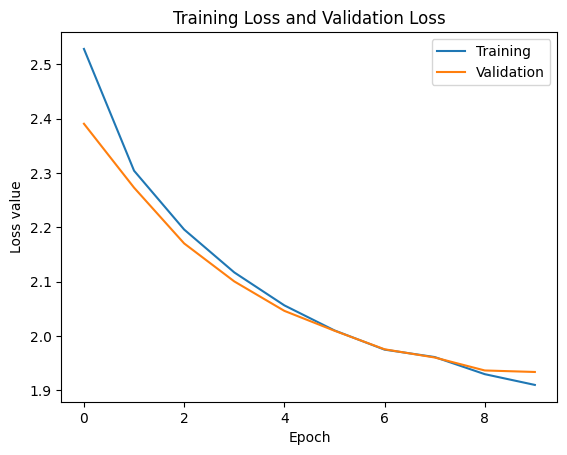

In [47]:
# plotting the performance of the model by showing the training loss and validation loss against the epochs

_plotdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/performance.csv")
plt.plot(_plotdf["loss"], label="Training")
plt.plot(_plotdf["val_loss"], label="Validation")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()


By looking at the lyrics generated by the model, we see that it is outputting some correct words but the sentences have no meaning.
Primary reason is that we are only using 100 characters for training in each row and model is trained only on 10 epochs.
The dataset is extremely big to be trained on any personal computer, therefore we have to make some compromise with the training and accuracy.
However we see that the loss is decreasing with the increasing epochs, and we cannot train it further due to hardware challenges.
